In [14]:
import requests
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt


In [4]:
# ---- Your reach ----
REACH_ID = "73218000131"
RIVER_NAME = "Cape Fear River"

# ---- What we pull from Hydrocron ----
FIELDS = "reach_id,time_str,wse,width,slope"

# ---- Hurricane Helene timing (use as a split/annotation) ----
HELENE_START = pd.Timestamp("2024-09-26T00:00:00Z")
HELENE_END   = pd.Timestamp("2024-09-28T00:00:00Z")
HELENE_SPLIT = pd.Timestamp("2024-09-27T00:00:00Z")

# ---- Hydrocron endpoint ----
BASE = "https://soto.podaac.earthdatacloud.nasa.gov/hydrocron/v1/timeseries"

# ---- Collections ----
# RiverSP_2.0 (often "C") then RiverSP_D for later availability in 2025+
COL_C = "SWOT_L2_HR_RiverSP_2.0"
COL_D = "SWOT_L2_HR_RiverSP_D"

# Collection transition (you can adjust if needed)
C_END   = pd.Timestamp("2025-05-03T23:59:59Z")
D_START = pd.Timestamp("2025-05-05T00:00:00Z")

# Start early enough to capture all SWOT-era availability for your reach
START_ALL = pd.Timestamp("2023-01-01T00:00:00Z")


In [5]:
def _parse_hydrocron_csv_text(text: str) -> pd.DataFrame:
    """
    Hydrocron sometimes returns CSV like:
      "reach_id,time_str,...\\n...\\n"
    This strips outer quotes and normalizes newlines, then reads with pandas.
    """
    text = text.strip()

    # Strip outer quotes if present
    if text.startswith('"') and text.endswith('"'):
        text = text[1:-1]

    # Convert escaped newlines to real newlines
    text = text.replace("\\n", "\n")

    df = pd.read_csv(StringIO(text))
    return df


In [6]:
def fetch_reach_window(
    reach_id: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    fields: str = FIELDS,
    collection_name: str | None = None,
) -> pd.DataFrame:
    """
    Fetch Hydrocron reach timeseries for a given time window.
    Returns a cleaned DataFrame with a parsed 'time' column.
    """
    params = {
        "feature": "Reach",
        "feature_id": str(reach_id),
        "start_time": start_time.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "end_time": end_time.strftime("%Y-%m-%dT%H:%M:%SZ"),
        "fields": fields,
    }
    if collection_name:
        params["collection_name"] = collection_name

    r = requests.get(BASE, params=params, headers={"Accept": "text/csv"}, timeout=60)

    # Raise useful error if request fails
    if r.status_code != 200:
        raise requests.HTTPError(f"HTTP {r.status_code} for {r.url}\nBody (first 300): {r.text[:300]}", response=r)

    df = _parse_hydrocron_csv_text(r.text)

    # Validate expected column
    if "time_str" not in df.columns:
        raise KeyError(f"'time_str' missing. Got columns: {list(df.columns)}")

    # Drop Hydrocron 'no_data' rows
    df = df[df["time_str"].ne("no_data")].copy()

    # Convert numeric + drop sentinels
    for col in ["wse", "width", "slope"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
            df.loc[df[col] <= -1e11, col] = pd.NA

    # Parse time
    df["time"] = pd.to_datetime(df["time_str"], utc=True, errors="coerce")
    df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

    return df


In [7]:
def find_latest_available_time(
    reach_id: str,
    collection_name: str,
    probe_days: int = 120,
    step_back_days: int = 30,
    max_back_days: int = 1200
) -> pd.Timestamp:
    """
    Walk backward from now until Hydrocron returns at least 1 row.
    Returns latest timestamp found in that response.
    """
    now = pd.Timestamp.utcnow()
    end_try = now
    backed = 0

    while backed <= max_back_days:
        start_try = end_try - pd.Timedelta(days=probe_days)

        try:
            df_probe = fetch_reach_window(
                reach_id=reach_id,
                start_time=start_try,
                end_time=end_try,
                fields=FIELDS,
                collection_name=collection_name
            )
            if len(df_probe) > 0:
                return df_probe["time"].max()

        except requests.HTTPError:
            pass

        end_try = end_try - pd.Timedelta(days=step_back_days)
        backed += step_back_days

    raise RuntimeError(f"Could not find latest available time within {max_back_days} days back for {collection_name}.")


In [8]:
def fetch_all_in_chunks(
    reach_id: str,
    start_time: pd.Timestamp,
    end_time: pd.Timestamp,
    collection_name: str,
    chunk_days: int = 120
) -> pd.DataFrame:
    """
    Fetch all data between start_time and end_time, chunked by chunk_days.
    Skips windows that return HTTP errors (e.g., empty/out-of-range).
    """
    parts = []
    t0 = start_time
    while t0 < end_time:
        t1 = min(t0 + pd.Timedelta(days=chunk_days), end_time)
        try:
            part = fetch_reach_window(
                reach_id=reach_id,
                start_time=t0,
                end_time=t1,
                fields=FIELDS,
                collection_name=collection_name
            )
            if len(part) > 0:
                parts.append(part)
        except requests.HTTPError:
            # skip bad windows; move on
            pass
        t0 = t1

    if not parts:
        return pd.DataFrame()

    df = pd.concat(parts, ignore_index=True)
    df = df.drop_duplicates(subset=["time_str"]).sort_values("time").reset_index(drop=True)
    return df


In [9]:
# 1) Get everything in RiverSP_2.0 (C) from START_ALL to C_END
df_c = fetch_all_in_chunks(
    reach_id=REACH_ID,
    start_time=START_ALL,
    end_time=C_END,
    collection_name=COL_C,
    chunk_days=180
)

# 2) Find latest for RiverSP_D and fetch from D_START to that latest
latest_d = find_latest_available_time(REACH_ID, COL_D)

df_d = fetch_all_in_chunks(
    reach_id=REACH_ID,
    start_time=D_START,
    end_time=latest_d,
    collection_name=COL_D,
    chunk_days=180
)

# 3) Combine + dedupe
df_all = pd.concat([df_c, df_d], ignore_index=True)
df_all = df_all.drop_duplicates(subset=["time_str"]).sort_values("time").reset_index(drop=True)

print("C rows:", len(df_c), "range:", (df_c["time"].min() if len(df_c) else None), "→", (df_c["time"].max() if len(df_c) else None))
print("D rows:", len(df_d), "range:", (df_d["time"].min() if len(df_d) else None), "→", (df_d["time"].max() if len(df_d) else None))
print("ALL rows:", len(df_all), "range:", df_all["time"].min(), "→", df_all["time"].max())

df_all.head(10)


C rows: 50 range: 2023-08-03 20:30:30+00:00 → 2025-05-01 06:37:05+00:00
D rows: 34 range: 2025-05-22 03:22:34+00:00 → 2026-01-07 02:26:41+00:00
ALL rows: 84 range: 2023-08-03 20:30:30+00:00 → 2026-01-07 02:26:41+00:00


,reach_id,time_str,wse,width,slope,wse_units,width_units,slope_units,time
0,73218000131,2023-08-03T20:30:30Z,2.7709,9.644234,-0.000029,m,m,m/m,2023-08-03 20:30:30+00:00
1,73218000131,2023-08-24T17:15:35Z,3.0150,28.965530,-0.000003,m,m,m/m,2023-08-24 17:15:35+00:00
2,73218000131,2023-09-04T04:49:49Z,2.7857,12.738155,0.000141,m,m,m/m,2023-09-04 04:49:49+00:00
3,73218000131,2023-09-14T14:00:41Z,3.2129,38.900759,0.000007,m,m,m/m,2023-09-14 14:00:41+00:00
4,73218000131,2023-10-05T10:45:43Z,30.9025,8.907564,-0.000287,m,m,m/m,2023-10-05 10:45:43+00:00
5,73218000131,2023-10-15T22:19:57Z,1.9693,13.375895,0.000091,m,m,m/m,2023-10-15 22:19:57+00:00
6,73218000131,2023-10-26T07:30:48Z,3.2272,9.322579,0.000027,m,m,m/m,2023-10-26 07:30:48+00:00
7,73218000131,2023-11-05T19:05:02Z,3.0149,46.220541,0.000004,m,m,m/m,2023-11-05 19:05:02+00:00
8,73218000131,2023-11-16T04:15:53Z,0.5783,9.330701,0.000010,m,m,m/m,2023-11-16 04:15:53+00:00
9,73218000131,2023-12-07T01:00:59Z,1.1654,9.069494,-0.000056,m,m,m/m,2023-12-07 01:00:59+00:00


In [10]:
raw_out = f"reach_{REACH_ID}_hydrocron_all_available.csv"
df_all.to_csv(raw_out, index=False)
raw_out


'reach_73218000131_hydrocron_all_available.csv'

In [11]:
pre = df_all[df_all["time"] < HELENE_SPLIT].copy()
post = df_all[df_all["time"] >= HELENE_SPLIT].copy()

pre_med = pre["wse"].median()
post_med = post["wse"].median()
delta = post_med - pre_med

print("Pre median WSE:", pre_med)
print("Post median WSE:", post_med)
print("Δ median (post-pre):", delta)

# Recovery: when rolling median returns within tolerance of pre-event median
d = df_all.set_index("time").sort_index()
wse_roll = d["wse"].rolling("60D").median()

tol = 0.25  # meters (tweak: 0.1–0.5 depending on how strict you want)
post_roll = wse_roll[wse_roll.index >= HELENE_END].dropna()
within = post_roll[(post_roll - pre_med).abs() <= tol]

if len(within) > 0:
    print("Recovery (within ±", tol, "m of pre median) by:", within.index.min())
else:
    print("No recovery within tolerance in available record (or too sparse).")


Pre median WSE: 3.2706
Post median WSE: 9.9936
Δ median (post-pre): 6.723000000000001
Recovery (within ± 0.25 m of pre median) by: 2024-10-15 00:17:12+00:00


'cape_fear_reach_73218000131_WSE_linkedin.png'

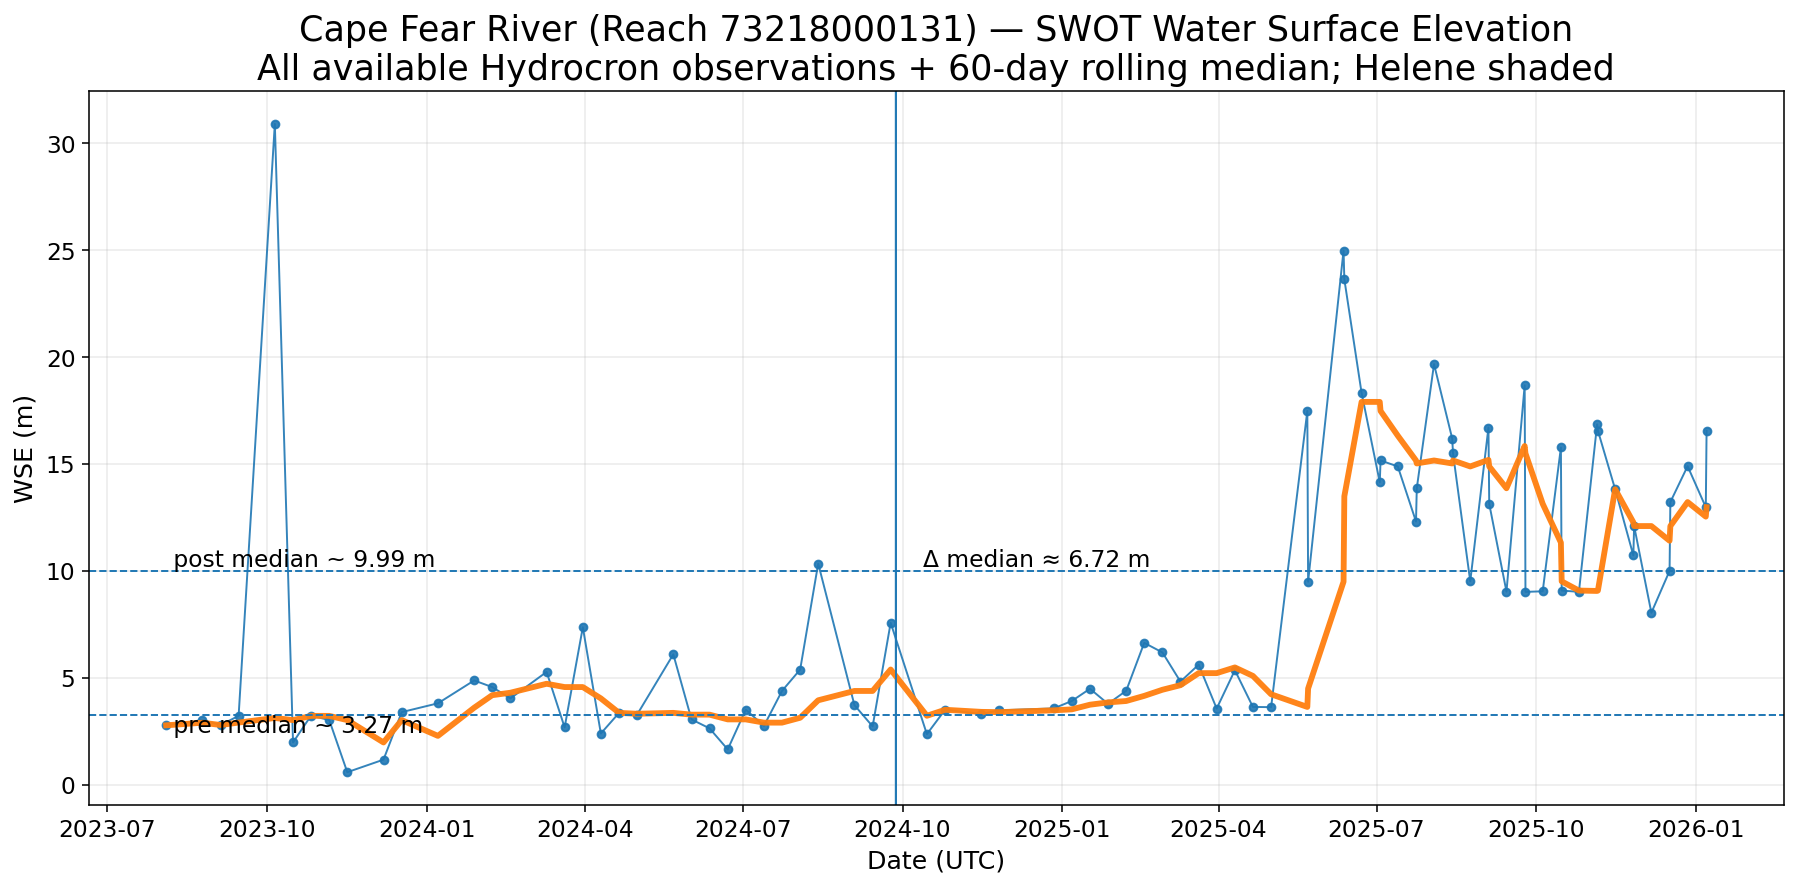

In [15]:
plt.rcParams.update({
    "figure.dpi": 140,
    "savefig.dpi": 300,
    "font.size": 12,
    "axes.titlesize": 18,
    "axes.labelsize": 13
})

fig, ax = plt.subplots(figsize=(13, 6.5))

# Raw points (and thin connecting line)
ax.plot(df_all["time"], df_all["wse"], marker="o", markersize=4, linewidth=1, alpha=0.9)

# Rolling median trend (smooth story line)
ax.plot(wse_roll.index, wse_roll.values, linewidth=3, alpha=0.95)

# Helene window shading + split line
ax.axvspan(HELENE_START, HELENE_END, alpha=0.18)
ax.axvline(HELENE_SPLIT, linewidth=1)

# Pre/Post median lines
ax.axhline(pre_med, linestyle="--", linewidth=1)
ax.axhline(post_med, linestyle="--", linewidth=1)

# Labels and title
ax.set_title(
    f"{RIVER_NAME} (Reach {REACH_ID}) — SWOT Water Surface Elevation\n"
    f"All available Hydrocron observations + 60-day rolling median; Helene shaded"
)
ax.set_xlabel("Date (UTC)")
ax.set_ylabel("WSE (m)")
ax.grid(True, alpha=0.25)

# Annotation: simple, readable
if pd.notna(delta):
    ax.text(df_all["time"].min(), post_med, f" post median ~ {post_med:.2f} m", va="bottom")
    ax.text(df_all["time"].min(), pre_med,  f" pre median ~ {pre_med:.2f} m", va="top")
    ax.text(HELENE_END + pd.Timedelta(days=15), post_med, f"Δ median ≈ {delta:.2f} m", va="bottom")

fig.tight_layout()

png_out = f"cape_fear_reach_{REACH_ID}_WSE_linkedin.png"
fig.savefig(png_out, bbox_inches="tight")
png_out


'cape_fear_reach_73218000131_WIDTH_linkedin.png'

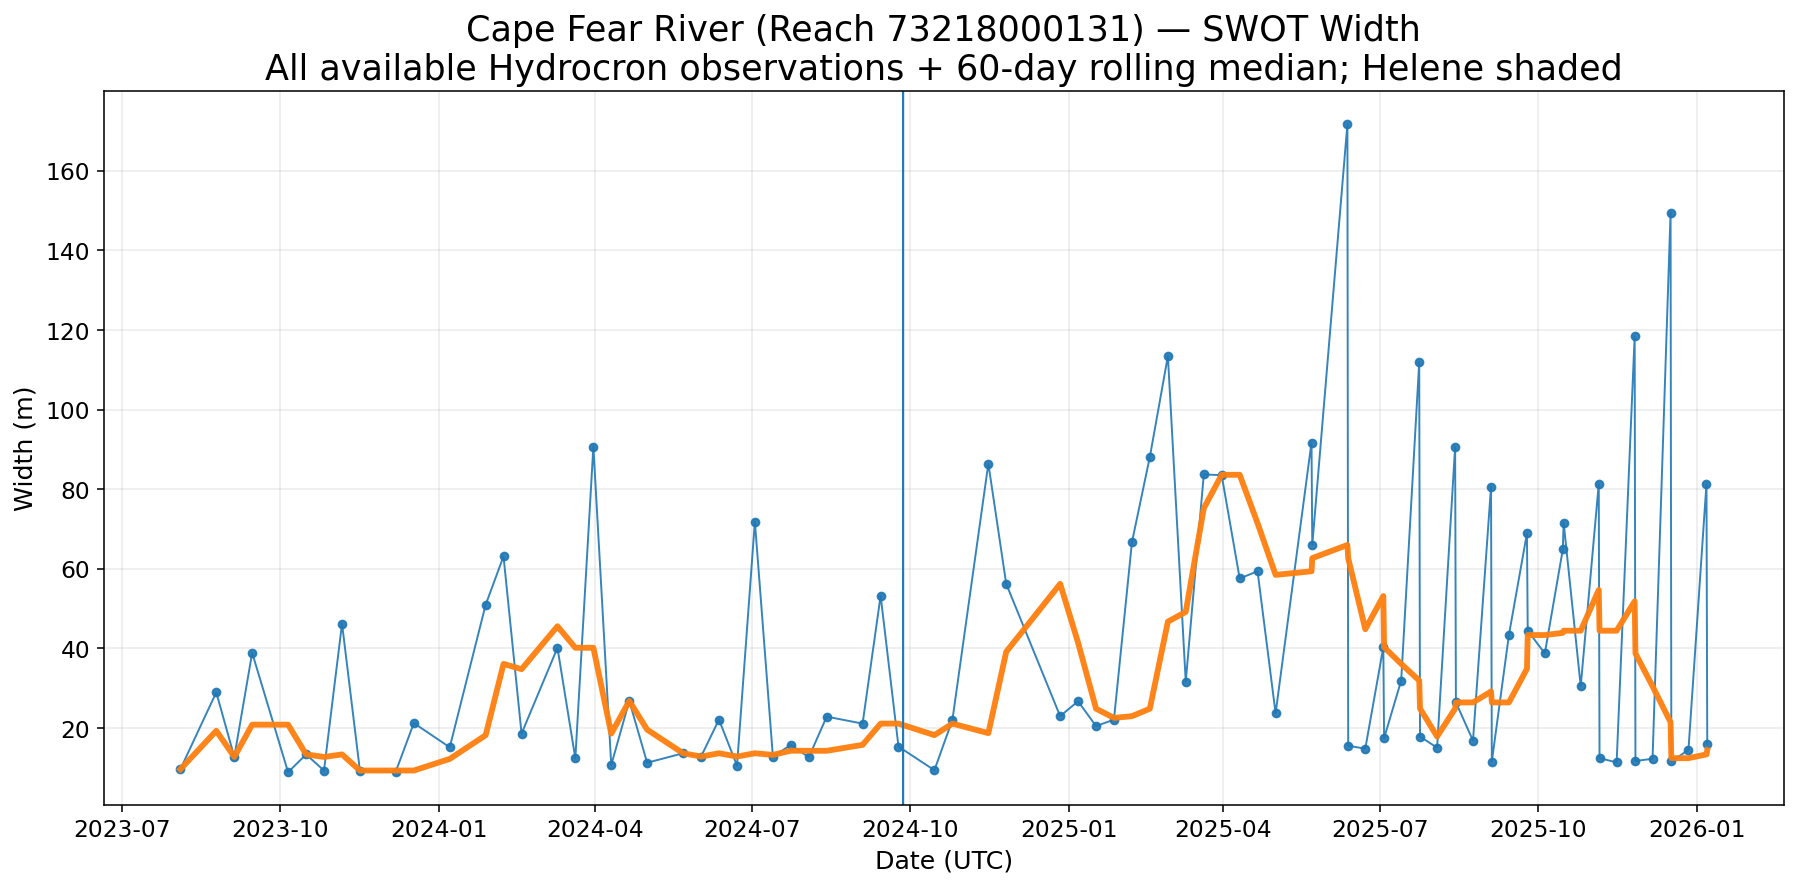

In [16]:
fig, ax = plt.subplots(figsize=(13, 6.5))
ax.plot(df_all["time"], df_all["width"], marker="o", markersize=4, linewidth=1, alpha=0.9)

width_roll = d["width"].rolling("60D").median()
ax.plot(width_roll.index, width_roll.values, linewidth=3, alpha=0.95)

ax.axvspan(HELENE_START, HELENE_END, alpha=0.18)
ax.axvline(HELENE_SPLIT, linewidth=1)

ax.set_title(f"{RIVER_NAME} (Reach {REACH_ID}) — SWOT Width\nAll available Hydrocron observations + 60-day rolling median; Helene shaded")
ax.set_xlabel("Date (UTC)")
ax.set_ylabel("Width (m)")
ax.grid(True, alpha=0.25)

fig.tight_layout()
png_width = f"cape_fear_reach_{REACH_ID}_WIDTH_linkedin.png"
fig.savefig(png_width, bbox_inches="tight")
png_width


'cape_fear_reach_73218000131_SLOPE_linkedin.png'

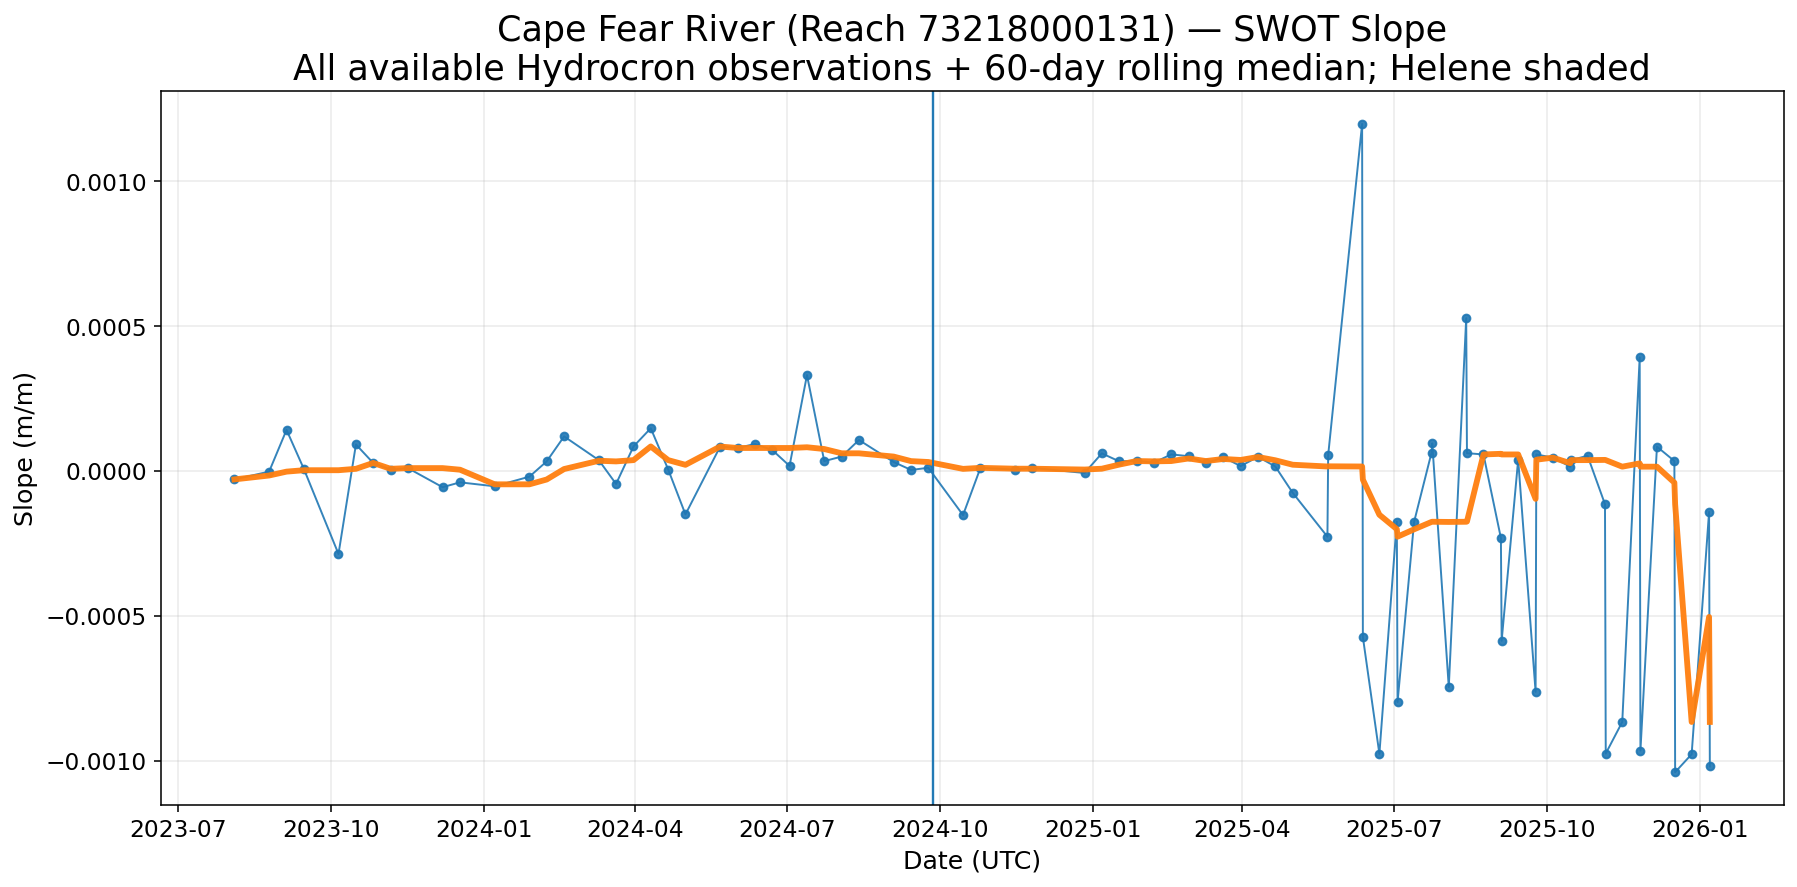

In [17]:
fig, ax = plt.subplots(figsize=(13, 6.5))
ax.plot(df_all["time"], df_all["slope"], marker="o", markersize=4, linewidth=1, alpha=0.9)

slope_roll = d["slope"].rolling("60D").median()
ax.plot(slope_roll.index, slope_roll.values, linewidth=3, alpha=0.95)

ax.axvspan(HELENE_START, HELENE_END, alpha=0.18)
ax.axvline(HELENE_SPLIT, linewidth=1)

ax.set_title(f"{RIVER_NAME} (Reach {REACH_ID}) — SWOT Slope\nAll available Hydrocron observations + 60-day rolling median; Helene shaded")
ax.set_xlabel("Date (UTC)")
ax.set_ylabel("Slope (m/m)")
ax.grid(True, alpha=0.25)

fig.tight_layout()
png_slope = f"cape_fear_reach_{REACH_ID}_SLOPE_linkedin.png"
fig.savefig(png_slope, bbox_inches="tight")
png_slope


In [18]:
def summarize(series: pd.Series):
    s = series.dropna()
    if len(s) == 0:
        return {"n": 0, "median": pd.NA, "mean": pd.NA, "p10": pd.NA, "p90": pd.NA}
    return {
        "n": int(s.size),
        "median": float(s.median()),
        "mean": float(s.mean()),
        "p10": float(s.quantile(0.10)),
        "p90": float(s.quantile(0.90)),
    }

rows = []
for var in ["wse", "width", "slope"]:
    pre_s = summarize(pre[var])
    post_s = summarize(post[var])
    rows.append({
        "variable": var,
        "pre_n": pre_s["n"],
        "post_n": post_s["n"],
        "pre_median": pre_s["median"],
        "post_median": post_s["median"],
        "delta_median_post_minus_pre": (post_s["median"] - pre_s["median"]) if (pre_s["n"] and post_s["n"]) else pd.NA,
        "pre_p10": pre_s["p10"],
        "pre_p90": pre_s["p90"],
        "post_p10": post_s["p10"],
        "post_p90": post_s["p90"],
    })

summary_df = pd.DataFrame(rows)
summary_df


,variable,pre_n,post_n,pre_median,post_median,delta_median_post_minus_pre,pre_p10,pre_p90,post_p10,post_p90
0,wse,33,51,3.270600,9.993600,6.723000,2.053060,7.105220,3.562200,17.475400
1,width,33,51,15.338631,38.742331,23.403700,9.393408,52.785249,12.283281,91.733648
2,slope,33,51,0.000027,0.000015,-0.000012,-0.000052,0.000117,-0.000966,0.000063


In [19]:
summary_out = f"reach_{REACH_ID}_pre_post_helene_summary.csv"
summary_df.to_csv(summary_out, index=False)
summary_out


'reach_73218000131_pre_post_helene_summary.csv'

In [20]:
caption = f"""
SWOT satellite snapshots of the {RIVER_NAME} (Reach {REACH_ID}) using NASA PO.DAAC Hydrocron.

What I’m looking at:
• Water surface elevation (WSE), width, and slope through time
• Hurricane Helene window shaded (late Sep 2024)
• A rolling-median trend line to highlight the state shift and recovery trajectory

Dynamic equilibrium angle:
Rivers are rarely “stable”—they fluctuate around a moving balance between flow energy, sediment supply, and channel form.
Extreme events can push the system away from its typical range (disturbance), and the post-event record can show
whether it relaxes back toward the prior state or settles into a new regime.

Quick signal here:
• Pre-event median WSE: {pre_med:.2f} m
• Post-event median WSE: {post_med:.2f} m
• Δ median (post − pre): {delta:.2f} m

Note: SWOT sampling is episodic (not daily), so this is best for post-event state + recovery, not the peak hydrograph.
""".strip()

print(caption)


SWOT satellite snapshots of the Cape Fear River (Reach 73218000131) using NASA PO.DAAC Hydrocron.

What I’m looking at:
• Water surface elevation (WSE), width, and slope through time
• Hurricane Helene window shaded (late Sep 2024)
• A rolling-median trend line to highlight the state shift and recovery trajectory

Dynamic equilibrium angle:
Rivers are rarely “stable”—they fluctuate around a moving balance between flow energy, sediment supply, and channel form.
Extreme events can push the system away from its typical range (disturbance), and the post-event record can show
whether it relaxes back toward the prior state or settles into a new regime.

Quick signal here:
• Pre-event median WSE: 3.27 m
• Post-event median WSE: 9.99 m
• Δ median (post − pre): 6.72 m

Note: SWOT sampling is episodic (not daily), so this is best for post-event state + recovery, not the peak hydrograph.
